In [1]:
import pandas as pd
import numpy as np

seed = "S1"
combinations = [
    'standard',
    '00011',
    '00111',
    '01111',
    '11111',
    '01110',
    '11110',
    '11100',
    '11000',
]
environment = [
    'continuous',
    'discrete'
]

base_dir = '../../evorobot-paper/data/critic-curriculum/multi-class/eval-batch'

env_stats = []
env_critic = []
env_curriculum = []

for env in environment:
    for comb in combinations:
        comb_path = f"{base_dir}/{env}/{comb}"

        stats = np.load(f"{comb_path}/stat{seed}.npy")
        
        with open(f"{comb_path}/{seed}.fit", 'r') as f:
            sf = f.readlines()
            cpu_time = float(sf[0].split('runtime ')[1])

        comb_stats =[
            dict(
                gen=int((i+6)/6),
                curriculum=comb,
                steps=stats[i],
                bestfit=stats[i+1],
                bestgfit=stats[i+2],
                avgfit=stats[i+3],
                cpu_time=cpu_time,
                env=env,
                id=env+comb,
                pos=combinations.index(comb)
            ) for i in range(0, len(stats), 6)
        ]
        env_stats += comb_stats

        if comb != 'standard':
            critic_data = np.load(f"{comb_path}/critic{seed}.npy")
            accuracy = []

            for row in critic_data:
                segments = row.split("\n")
                for segment in segments:
                    if "accuracy" in segment:
                        acc = segment.split("0.")[1][:2]
                        accuracy.append(
                            dict(
                                accuracy=float(acc)/100,
                                curriculum=comb,
                                env=env,
                                id=env+comb,
                                pos=combinations.index(comb)
                            )
                        )
            
            curriculum_data = np.load(f"{comb_path}/curriculum{seed}.npy", allow_pickle=True)
            curriculum = []

            for row in curriculum_data:
                row['curriculum'] = comb
                row['env'] = env
                row['id'] = env+comb
                row['active'] = 1 if sum(row['selection']) > 0 else 0
                curriculum.append(row)

            env_curriculum += curriculum
            env_critic += accuracy


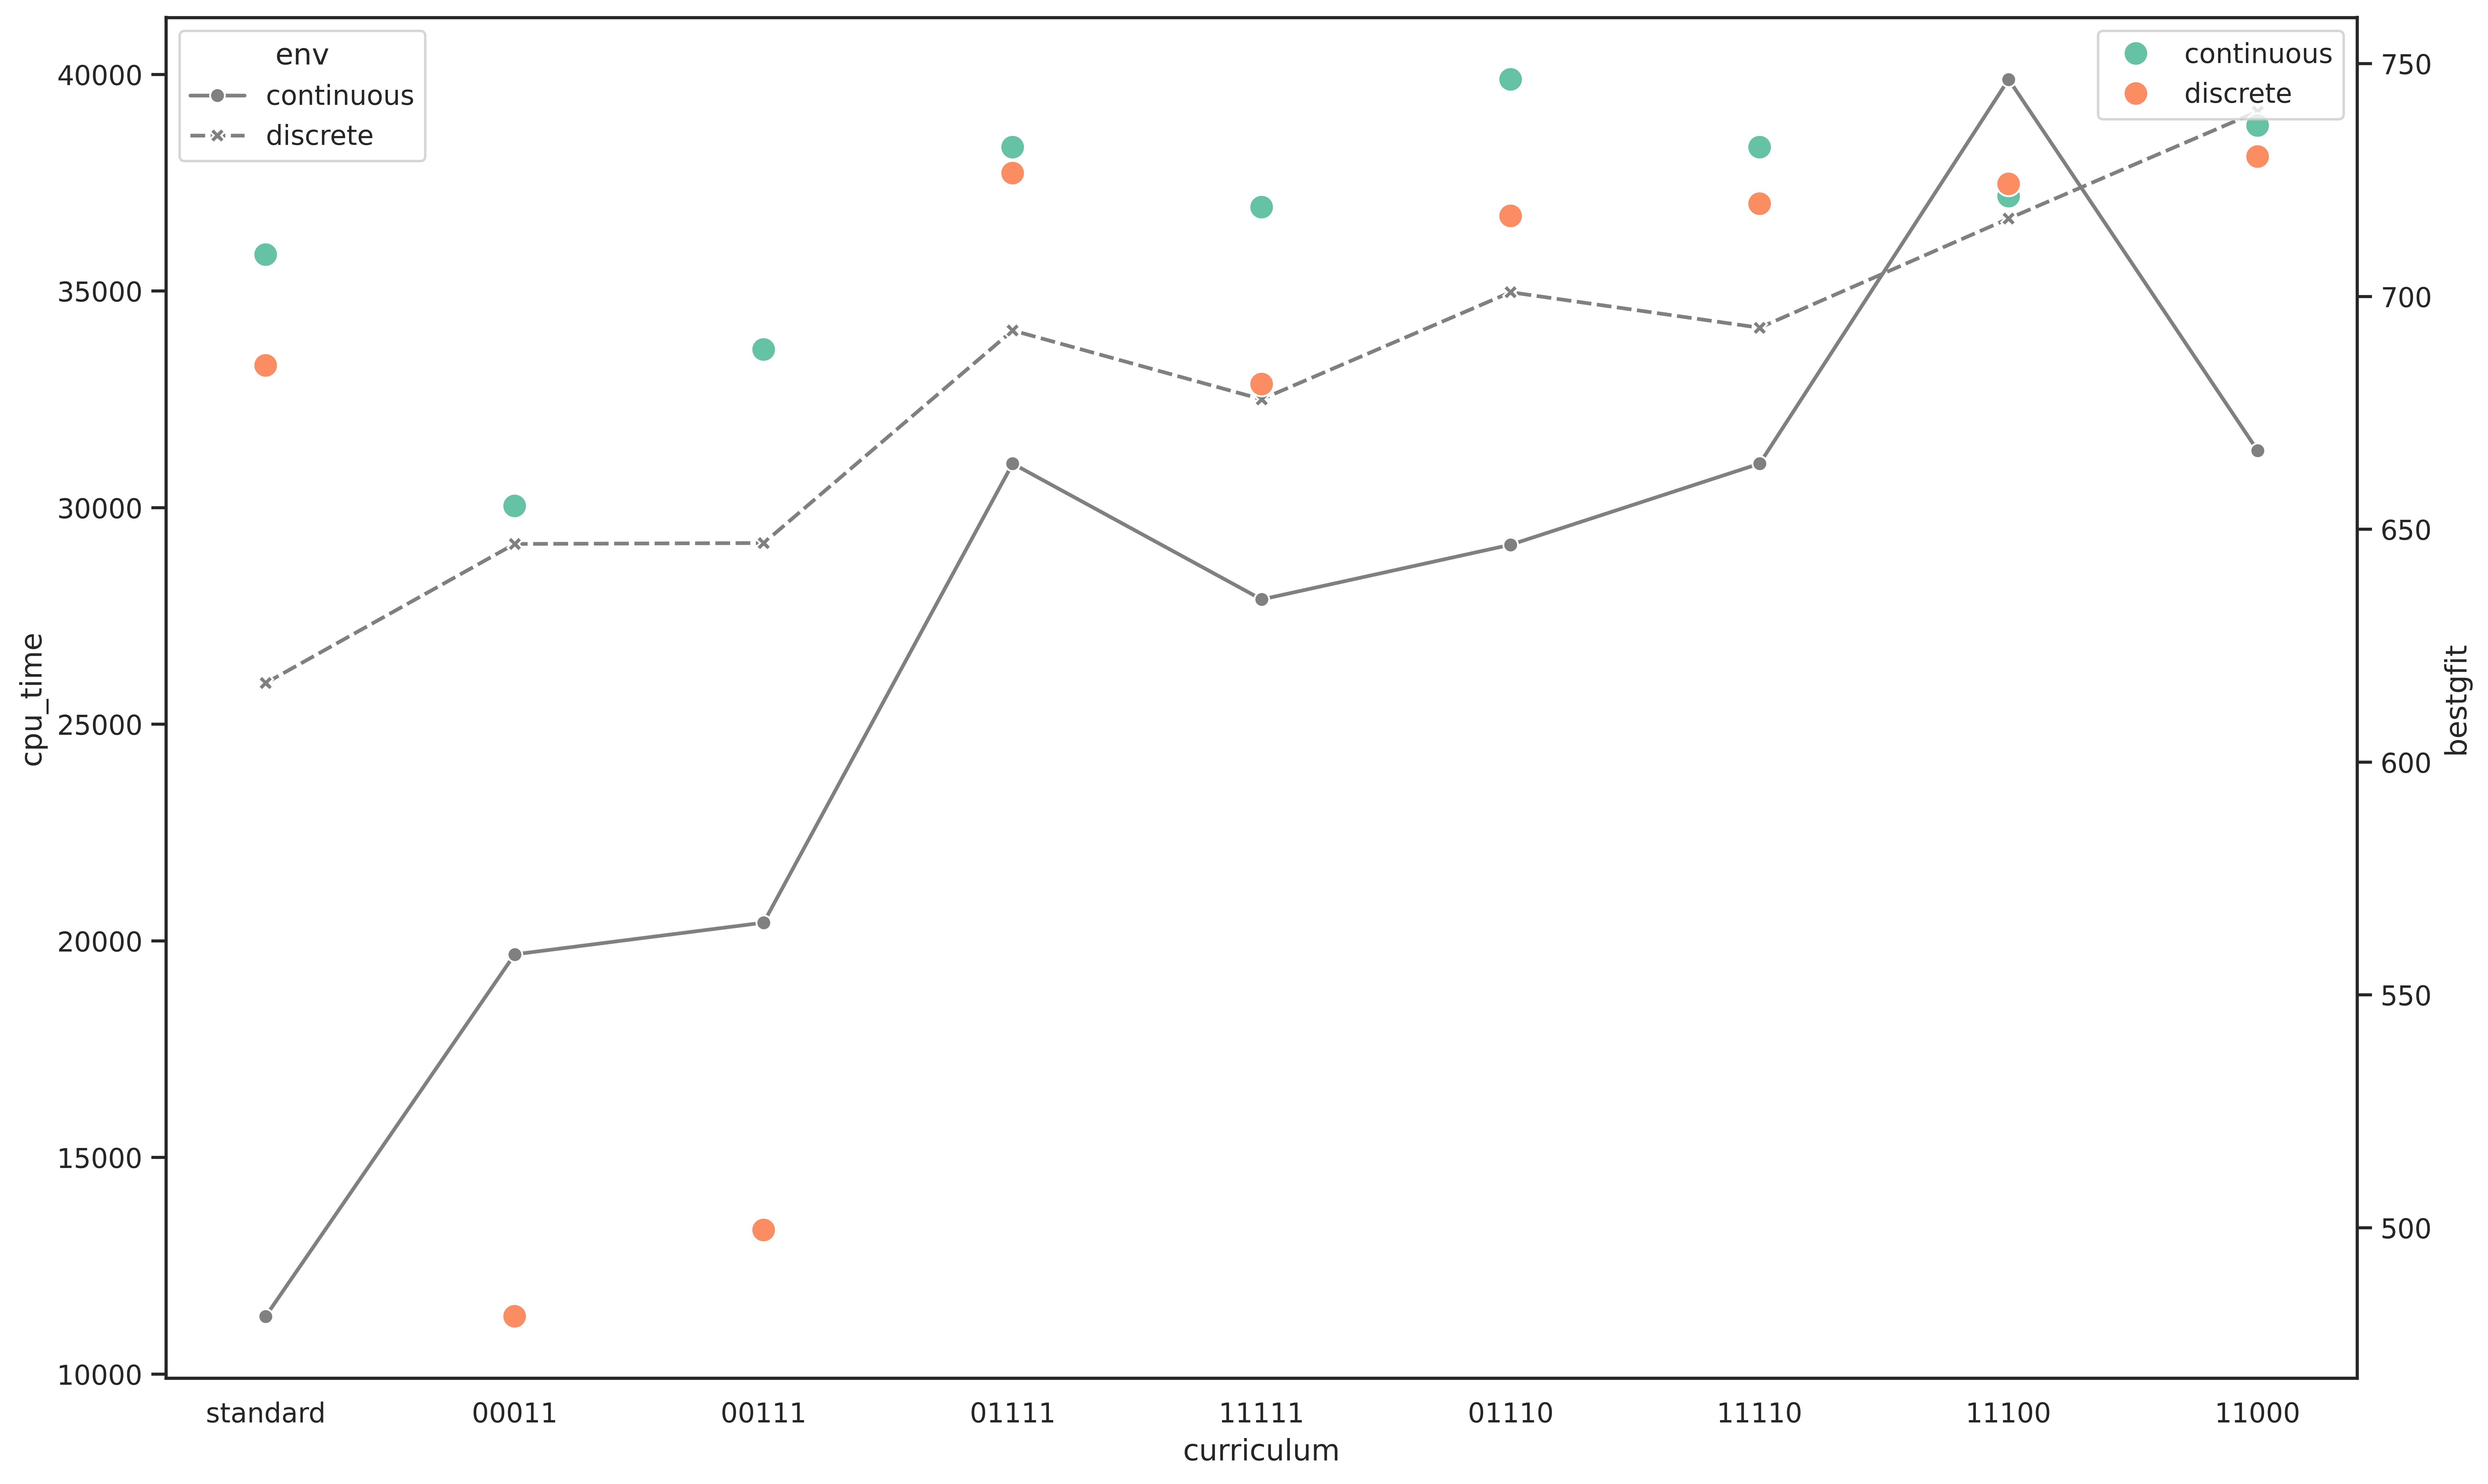

In [2]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, style='white')
plt.figure(dpi=600)
sns.set_palette("Set2")

stats_data = pd.DataFrame(env_stats)
agg_stats_data = stats_data.groupby('id').max()
agg_stats_data = agg_stats_data.sort_values(by=['pos'])

sns.lineplot(agg_stats_data, x='curriculum', y='cpu_time', markers=True, style='env', color='gray')
ax2 = plt.twinx()
sns.scatterplot(agg_stats_data, x='curriculum', y='bestgfit', hue='env', s=100, ax=ax2)
plt.legend(loc='upper right')

(400.0, 1600.0)

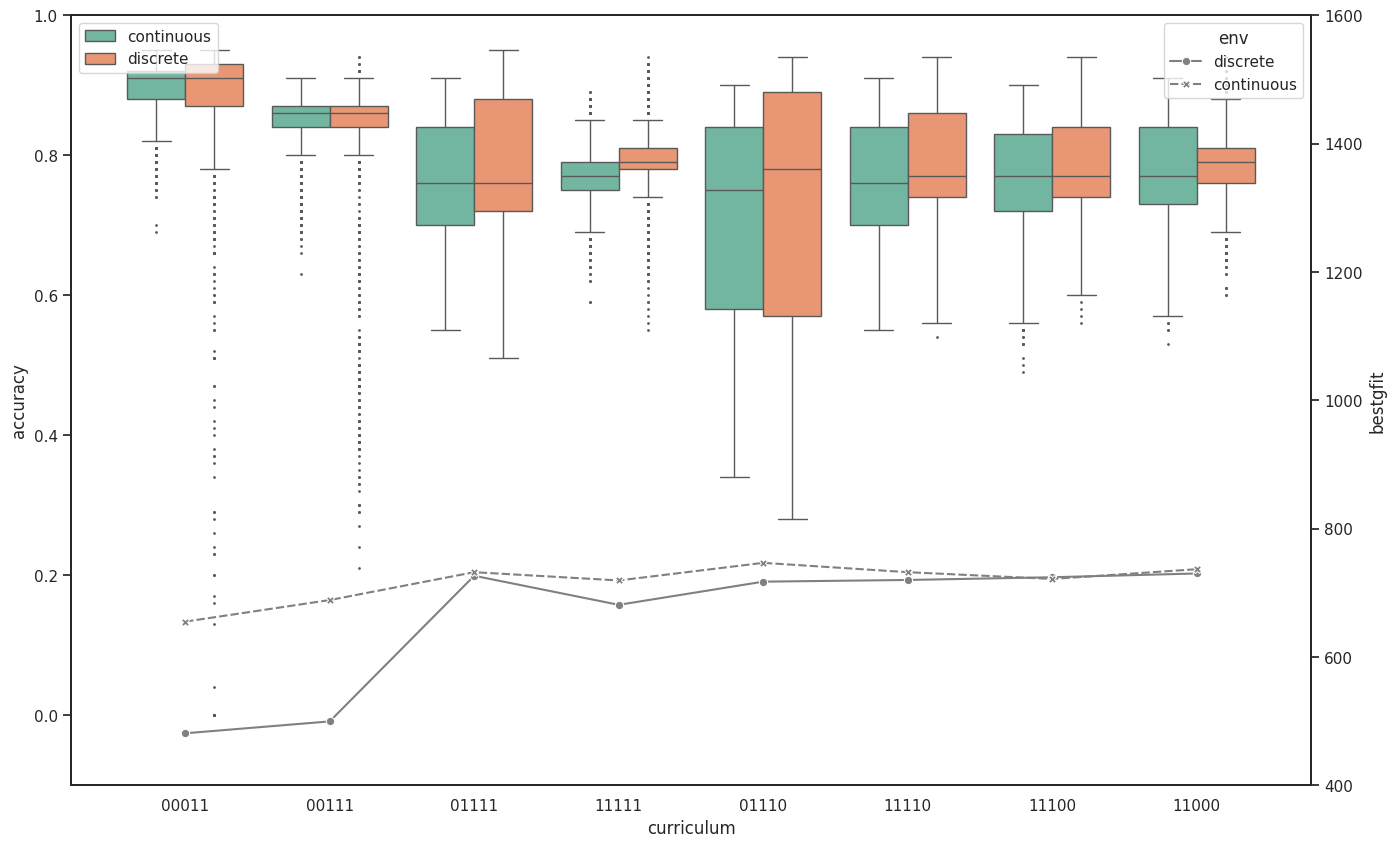

In [3]:
critic_data = pd.DataFrame(env_critic)
critic_data = critic_data.sort_values(by=['pos'])
agg_just_curriculum = agg_stats_data.query("curriculum != 'standard'")

sns.boxplot(data=critic_data, x='curriculum', y='accuracy', hue='env', fliersize=1)
plt.legend(loc='upper left')
plt.ylim([-0.1, 1])
ax2 = plt.twinx()
sns.lineplot(agg_just_curriculum, x='curriculum', y='bestgfit', markers=True, style='env', color='gray', ax=ax2)
ax2.set_ylim([400, 1600])

In [18]:
curriculum_data = pd.DataFrame(env_curriculum)

analysis_data = []
for curr in agg_just_curriculum.to_records():
    active = curriculum_data.query(f"id == '{curr[0]}'").active.sum()
    analysis_data.append(
        dict(
            id=curr[0],
            generations=curr[1],
            curriculum=curr[2],
            bestgfit=curr[5],
            cpu_time=curr[7],
            env=curr[8],
            active=active,
            active_proportion=active/curr[1]
        )
    )

analysis = pd.DataFrame(analysis_data)

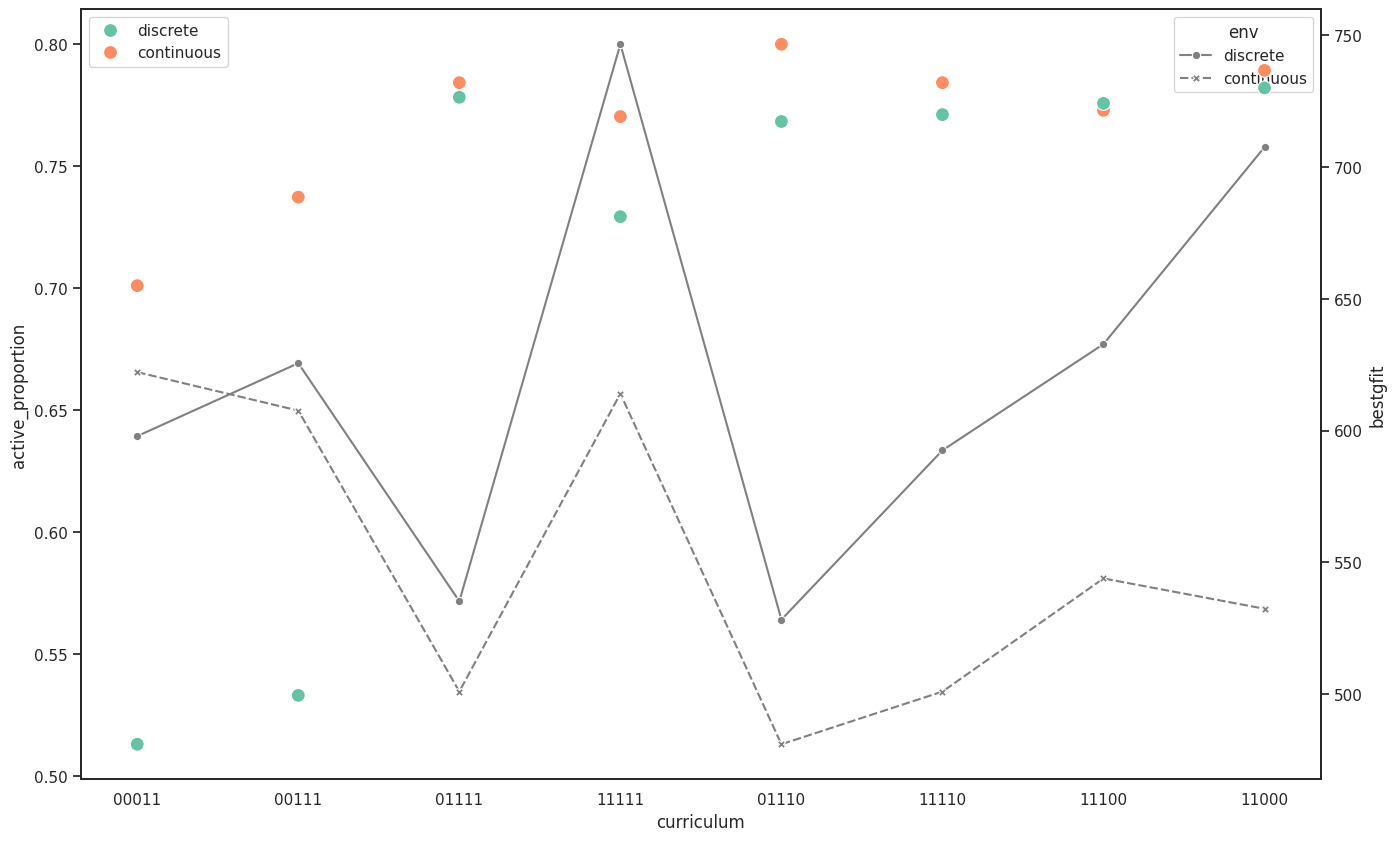

In [34]:
sns.lineplot(analysis, x='curriculum', y='active_proportion', markers=True, style='env', color='grey')
ax2 = plt.twinx()
sns.scatterplot(analysis, x='curriculum', y='bestgfit', hue='env', s=100, ax=ax2)
plt.legend(loc='upper left')